# Sparse Inverse Covariance Routine with Validation tests

In this notebook, the required functions to perform the inverse covariance calculation (included zero-padding functions so things can be performed exclusively with python) are laid out. Toward the end, we perform some simple validation tests to ensure things are being computed as expected and follow up by providing code to benchmark this python implimentation of the inverse covariance routine. 

In [1]:
import numpy as np
import cupy as cp
import seaborn as sns
import matplotlib.pyplot as plt
import corrcal
from cupyx.profiler import benchmark

hera_cal is not installed. Some gridding features unavailable.
pyfof is not installed. Some gridding features unavailable.


## Main Algorithm Work

We need functions that will zero pad all of the input matrices since there are many instances in the computation where explicit block matrix mutliplication is performed. To complicate matters further, the diffuse matrix is block diagonal in its dense form, though we only plan to keep the sparse (non-zero) elements in memory. This makes performing matrix multiplication difficult especially since the blocks have differing numbers of rows, even though they all have the same number of columns. 

In order to still achieve this in a reasonably simple manor using python, we must first pad each of the arrays such that they are all composed of blocks of the same size, with size equal to the largest block in the diffuse matrix. In all blocks with fewer rows than the largest block, the entries of these blocks will consist of their usual entries, while the rest of the values will be zero.

In [2]:

def zeropad(array, edges, xp):
    """
    Pads an input noise, diffuse, or source matrix with zeros according to
    the largest redundant block in the diffuse matrix. Note that although the input arrays
    will have a 1D or 2D shape for noise or diff/sourc matrices respectively, the routine converts 
    to either 2D or 3D shapes so we can easily perform block mutliplication in the inverse covariance
    function.

    Parameters
    ----------
    array: Input noise, diffuse, or source matrix. Should be of shape (n_bl,), (n_bl, n_eig), or (n_bl, n_src) respectively
    edges: Array containing indices corresponding to the edges of redundant blocks in the diffuse matrix
            Note that the "edges" index the beginning row (or "edge") of each redundant block
    
    Returns
    -------
    out: The output zero-padded noise, diffuse, or source matrix where each matrix has also been reshaped 
        to be easily used in the inverse covariance function that performs mutliplication over blocks. The 
        output matrices have shapes of either (n_blocks, largest_red_block), (n_blocks, largest_red_block, n_eig), 
        or (n_blocks, largest_red_block, n_src) respectively.
    """

    largest_block = xp.diff(edges).max()
    n_blocks = edges.size - 1

    if array.ndim == 1:   #should only be the case for the noise matrix
        out = xp.zeros((n_blocks, int(largest_block)))
    else:
        out  = xp.zeros((n_blocks, int(largest_block), int(array.shape[1])))

    for block, (start, stop) in enumerate(zip(edges, edges[1:])):
        start, stop = int(start), int(stop)
        out[block, :stop - start] = array[start:stop]
    
    return out

def undo_zeropad(array, edges, xp):
    """
    Undoes (essentially does the exact opposite of) the work of the zeropad function.
    
    Parameters
    ----------
    array: Input noise, diffuse, or source matrix. Should be of shape (n_bl,), (n_bl, n_eig), or (n_bl, n_src) respectively
    edges: Array containing indices corresponding to the edges of redundant blocks in the diffuse matrix.
            Note that the "edges" index the beginning row (or "edge") of each redundant block

    Returns
    -------
    out: A dense, unzero-padded array. If an array is given to the zeropad function, this routine will return that original array
        provided the edges array is the same as the one used to pad the original array with zeros.
    """

    if array.ndim == 2:   #once again only the case for the noise matrix
        out = xp.zeros((int(edges[-1])))
    else:
        out = xp.zeros((int(edges[-1]), int(array.shape[2])))

    for block, (start, stop) in enumerate(zip(edges, edges[1:])):
        start, stop = int(start), int(stop)
        out[start:stop] = array[block, :stop - start]

    return out

Below is the algorithm used to calculate the components that make up the inverse covariance in its sparse 2-level form.

Recall, what we have is $N$, $\Delta$, $\Sigma$. What we want is $N^{-1}$, $\Delta '$, $\Sigma '$. And the key point is that we never want to keep the sparse form of the covariance $C$ in memory. To achieve this, one first needs to write down the inverse of $\tilde{C}^{-1} = (N + \Delta \Delta^{\dagger})^{-1} = N^{-1} - N^{-1} \Delta (\mathcal{I} + \Delta^{\dagger} N^{-1} \Delta)^{-1} \Delta^{\dagger} N^{-1}$.

$~$
##### The first part of the code (calculation of $N^{-1}$ and $\Delta$) is as follows:

Step 1: Calculate a temp matrix, we define as $T \equiv N^{-1} \Delta$. This allows us to write the woodbury identity as,

$$ N^{-1} - N^{-1} \Delta (\mathcal{I} + \Delta^{\dagger} N^{-1} \Delta)^{-1} \Delta^{\dagger} N^{-1} = N^{-1} - T (\mathcal{I} + \Delta^{\dagger} T)^{-1} T^{\dagger} $$

Step 2: Calculate Chol(--term in brackets--). Ie.

$$\text{Chol}(\mathcal{I} + \Delta^{\dagger} T) = L_{\Delta}L_{\Delta}^{\dagger}$$

Step 3: Calculate the inverse of the lower trangular matrix. Ie. calculate $L_{\Delta}^{-1}$. We can quickly calculate the Hermitian' conjugate and this allows us to write,

$$N^{-1} - T (L_{\Delta}^{-1})^{\dagger}(L_{\Delta}^{-1}) T^{\dagger}$$

Step 4: Calculate $\Delta ' \equiv  T (L_{\Delta}^{-1})^{\dagger}$

Finally, return $\Delta '$. We note that $\Delta'^{\dagger}$ is calculated straightforwardly at this point and does not contain any new information after we already have $\Delta$

$$~$$
##### The second part (calculation of $\Sigma$) is as follows:


Finding $\Sigma'$ is a little more involved, but follows the same framework as the steps above. We begin by expanding the full inverse covariance as follows:

$$ C^{-1} = (\tilde{C} + \Sigma \Sigma^{\dagger})^{-1} = \tilde{C}^{-1} - \tilde{C}^{-1}\Sigma(\mathcal{I} + \Sigma^{\dagger}\tilde{C}^{-1}\Sigma)^{-1}\Sigma^{\dagger}\tilde{C}^{-1} $$

$$ = (N^{-1} - \Delta' \Delta'^{\dagger}) - (N^{-1} - \Delta' \Delta'^{\dagger})\Sigma(\mathcal{I} + \Sigma^{\dagger}(N^{-1} - \Delta' \Delta'^{\dagger})\Sigma)^{-1}\Sigma^{\dagger}(N^{-1} - \Delta' \Delta'^{\dagger}) $$

A couple observations are in order. We obviously don't need to re-calculate $N^{-1}$ and $\Delta'$, since they're calculated above. However, we can see two combinations of matrices that make up nearly the entire line above. Namely, we will define,

$$ A \equiv N^{-1}\Sigma ~~~~~~~~\text{and}~~~~~~~~ B \equiv \Sigma^{\dagger} \Delta',$$

so that the inverse covariance can be written as:

$$ = (N^{-1} - \Delta' \Delta'^{\dagger}) - (N^{-1}\Sigma - \Delta' \Delta'^{\dagger}\Sigma)(\mathcal{I} + \Sigma^{\dagger}N^{-1}\Sigma - \Sigma^{\dagger}\Delta' \Delta'^{\dagger}\Sigma)^{-1}(\Sigma^{\dagger}N^{-1} - \Sigma^{\dagger}\Delta' \Delta'^{\dagger}) $$

$$ = (N^{-1} - \Delta' \Delta'^{\dagger}) - (A - \Delta' B^{\dagger})(\mathcal{I} + A^{\dagger}\Sigma - BB^{\dagger})^{-1}(A^{\dagger} - B \Delta'^{\dagger}) $$

Further notice that with the additional definition $W \equiv (A - \Delta' B^{\dagger})$, the inverse covariance can finally be written as:


$$ = (N^{-1} - \Delta' \Delta'^{\dagger}) - W(\mathcal{I} + A^{\dagger}\Sigma - BB^{\dagger})^{-1}W^{\dagger}. $$

Of course, the part we are really concerned with is the second term above if we want to calculate $\Sigma$. Therefore, for the algorithm, our steps are now the following:

Step 1: Calculate temp matrices A, B, W all defined above.

Step 2: Calculate the Cholesky decomp of the inverse term in parenth's:

$$ \text{Chol}(\mathcal{I} + A^{\dagger}\Sigma - BB^{\dagger}) = L_{\Sigma}L_{\Sigma}^{\dagger} $$

This allows the term of interest to then be written as:

$$ W(L_{\Sigma}^{-1})^{\dagger}(L_{\Sigma}^{-1})W^{\dagger} $$

Step 3: Calculate $\Sigma' = W(L_{\Sigma}^{-1})^{\dagger}$

Below we provide a python implimentation of the algorithm just shown above, with the option to run the computatoin on the gpu using cupy or on purely on the cpu using numpy.

In [3]:
def inverse_covariance(N, Del, Sig, edges, xp):
    """
    Given the components of the 2-level sparse covariance object, computes the components of the inverse covariance object. Currectly does not 
    support the option to return the determinant of the covariance.

    TODO: Add option to return the determinant

    Parameters
    ----------
    N: Noise 
    Del: \Delta (diffuse) sky component matrix with shape n_bl x n_eig
    Sig: \Sigma Source component matrix with shape n_bl x n_src
    edges: Array controlling the start and stop of the redundant blocks in the sparse diffuse matrix
    xp: Choice of running on the gpu (xp = cp) or cpu (xp = np)

    Returns
    -------
    N^-1: Inverse noise matrix
    Del': The primed version of the diffuse sky matrix
    Sig': The primed version of the source component matrix
    """
    
    Del = zeropad(Del, edges, xp = xp)
    Sig = zeropad(Sig, edges, xp = xp)
    N_inv = 1/N     
    N_inv = zeropad(N_inv, edges, xp = xp)

    temp = N_inv[..., None] * Del    
    temp2 = xp.transpose(Del, [0, 2, 1]) @ temp
    L_del = xp.linalg.cholesky(xp.eye(Del.shape[2])[None, ...] + temp2)   
    Del_prime = temp @ xp.transpose(xp.linalg.inv(L_del).conj(), [0, 2, 1]) 
          
    A = N_inv[..., None] * Sig
    B = xp.transpose(Sig.conj(), [0, 2, 1]) @ Del_prime
    W = A - Del_prime @ xp.transpose(B.conj(), [0, 2, 1])
    L_sig = xp.linalg.cholesky(
        xp.eye(Sig.shape[2]) + xp.sum(xp.transpose(A.conj(), [0, 2, 1]) @ Sig, axis = 0) - xp.sum(B @ xp.transpose(B.conj(), [0, 2, 1]), axis = 0)
    )
    Sig_prime = W @ xp.linalg.inv(L_sig).T.conj()[None, ...]

    N_inv = undo_zeropad(N_inv, edges, xp = xp)
    Del_prime = undo_zeropad(Del_prime, edges, xp = xp)
    Sig_prime = undo_zeropad(Sig_prime, edges, xp = xp)   

    return N_inv, Del_prime, Sig_prime

### Simulation Considerations

In order to properly simulate that we've calculated the right thing in running the code above, we will first need a method of recovering the dense form of the sparse diffuse matrix. This is important since the existing algorithm accepts and works with simply the sparse representation of the diffuse matrix. Additionally, the current corrcal tutorial provides us with just the sparse form of the diffuse matrix. It is helpful, however, to also be able to convert a dense diffuse matrix to its analogous sparse form using only an array of "edges", the number of baselines, and the number of eigenmodes used to construct the array. 

In [4]:
def sparse_to_dense(Array, n_bls, n_eig, edges, xp = cp):
    """
    Converts a sparse diffuse matrix back to its original dense form

    Parameters
    ----------
    Array: The sparse diffuse matrix
    n_bls: Number of baselines used in the calculation of the sparse diffuse matrix
    n_eig: Number of eigenmodes being used to construct the sparse diffuse matrix
    edges: An array controlling the edges of the redundant group blocks in the sparse diffuse matrix
    xp: The choice to either run the computation on the gpu (xp = cp) or cpu (xp = np)

    Returns
    -------
    out: The dense version of the diffuse matrix. Note this matrix has shape (n_bls x n_eig*n_grps) where n_grps = # redundant groups
    """
    
    n_grp = edges.size - 1
    out = xp.zeros((n_bls, n_eig*n_grp))
    for i, (start, stop) in enumerate(zip(edges, edges[1:])):
        out[start:stop, i*n_eig : (i+1)*n_eig] = Array[start:stop]
        
    return out

def dense_to_sparse(Array, n_bls, n_eig, edges, xp = cp):
    """
    Converts a dense diffuse matrix that is block diagonal to a sparse form by only storing the non-zero entries
    
    Parameters
    ----------
    Array: The dense diffuse matrix
    n_bls: Number of baselines used in the calculation of the sparse diffuse matrix
    n_eig: Number of eigenmodes being used to construct the sparse diffuse matrix
    edges: An array controlling the edges of the redundant group blocks in the sparse diffuse matrix
    xp: The choice to either run the computation on the gpu (xp = cp) or cpu (xp = np)
    
    Returns
    -------
    out: The sparse version of the diffuse matrix with redundant blocks along the rows. Overall shape will be (n_bls x n_eig)
    """

    out = xp.zeros((n_bls, n_eig))
    for i, (start, stop) in enumerate(zip(edges, edges[1:])):
        out[start:stop] = Array[start:stop, i*n_eig : (i+1)*n_eig]

    return out

Being decidedly clever, we can simply combine the two routines into one and let the computer figure out which routine to use based on the shape of the input array.

In [5]:
def sparden_convert(Array, n_bl, n_eig, edges, xp = cp):
    """
    Converts either the dense diffuse matrix to sparse, or the sparse diffuse matrix to dense. The array (either dense or sparse)
    should be simply handed to the function and the desired operation (sparse-to-dense or dense-to-sparse) will be performed automatically

    Parameters
    ----------
    Array: Either dense or sparse diffuse matrix
    n_bls: Number of baselines used in the calculation of the sparse diffuse matrix
    n_eig: Number of eigenmodes being used to construct the sparse diffuse matrix
    edges: An array controlling the edges of the redundant group blocks in the sparse diffuse matrix
    xp: The choice to either run the computation on the gpu (xp = cp) or cpu (xp = np)

    Returns
    -------
    out: If the dense form was provided, the sparse form with shape (n_bls x n_eig) will be returned. If the sparse form was provided, the dense
        form with shape (n_bls x n_eig*n_grps) with n_grps = # redundant groups will be returned.
    """
    
    if Array.shape[1] == n_eig:
        n_grp = edges.size - 1
        out = xp.zeros((n_bl, n_eig*n_grp))
        for i, (start, stop) in enumerate(zip(edges, edges[1:])):
            out[start:stop, i*n_eig : (i+1)*n_eig] = Array[start:stop]
    else:
        out = xp.zeros((n_bl, n_eig))
        for i, (start, stop) in enumerate(zip(edges, edges[1:])):
            out[start:stop] = Array[start:stop, i*n_eig : (i+1)*n_eig]

    return out

#### Possible TODO: 
Get this routine running below for running streamlined timing tests

In [6]:
def benchmark_fun(f, *args, n_repeat, **kwargs):
    test_results = str(benchmark(f, (args, kwargs), n_repeat=n_repeat))
    test_results = test_results.split()
    cpu_t, gpu_t = float(test_results[3]/1e6, float(test_results[14])/1e6)
    return cpu_t, gpu_t

## Validation Tests

Let's perform some tests to ensure that the components we are calculating really do make up the inverse noise and the primed versions of the delta and sigma matrices. 

In [7]:
#the main parametes describing our problem.
n_bl = 50
n_eig = 3
n_src = 6
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 10))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64')**2   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')

#actually go and find inverse components
N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat, sim_diff_mat, sim_src_mat, edges=edges, xp = xp)

The edges of the redundant blocks have indices[ 0  5 11 20 25 32 33 35 41 48 50]


At this point, we must recover the dense form of both $\Delta$ and $\Delta'$. Of course, we have two ways to do this. As purely a test of validation, we first test the use of the two separated routines.

In [8]:
sim_diff_mat_dense = sparse_to_dense(sim_diff_mat, n_bls=n_bl, n_eig=n_eig, edges=edges, xp = cp)
Del_p_dense = sparse_to_dense(Del_p, n_bls=n_bl, n_eig=n_eig, edges=edges, xp=cp)

Now convert back to dense:

In [9]:
sim_diff_mat_v2 = dense_to_sparse(sim_diff_mat_dense, n_bls=n_bl, n_eig=n_eig, edges=edges, xp = cp)
Del_p_v2 = dense_to_sparse(Del_p_dense, n_bls=n_bl, n_eig=n_eig, edges=edges, xp=cp)

In [10]:
if np.all(sim_diff_mat == sim_diff_mat_v2) and np.all(Del_p_v2 == Del_p) == True:
    print("The dense to sparse routine is able to recover the original sparse matrix")
else:
    print("There is something wrong with the sparse-to-dense or dense-to-sparse routines")

The dense to sparse routine is able to recover the original sparse matrix


That was really just a test of the two separated routines - first, sparse to dense, and second, dense to sparse. The results show that indeed these routines work as indended. The easier method is simply to use the general routine for converting sparse to dense and vice-versa, which I call sparden_convert.

In [11]:
sim_diff_mat_dense = sparden_convert(sim_diff_mat, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp)
Del_p_dense = sparden_convert(Del_p, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp)

In [12]:
#convert back to sparse for the check in the cell directly below
sim_diff_mat_v2 = sparden_convert(sim_diff_mat_dense, n_bl=n_bl, n_eig=n_eig, edges=edges, xp=cp)

In [13]:
if np.all(sim_diff_mat == sim_diff_mat_v2):
    print("The dense to sparse routine is able to recover the original sparse matrix")
else:
    print("There is something wrong with the sparse-to-dense or dense-to-sparse routines")

The dense to sparse routine is able to recover the original sparse matrix


Now that we know the we can recover the dense diffuse matrix from its sparse form, it would be interesting to visualize its block diagonal form. Let's see this below.

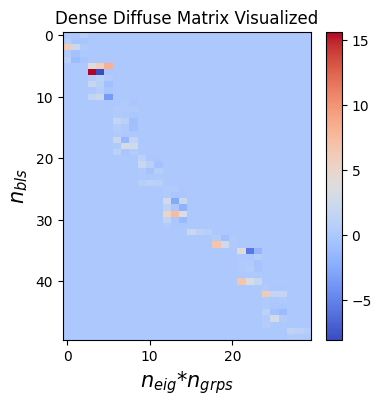

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cp.asnumpy(Del_p_dense), cmap='coolwarm', aspect='auto')
ax.set_title("Dense Diffuse Matrix Visualized")
ax.set_xlabel("$n_{eig}$*$n_{grps}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

#would like the center to be at 0, vmin and vmax only differ by a sign

As for validating the correctness of our solutions given by our inverse covariance routine, this can be done in two ways. Recall the object we started with was a 2-level sparse covariance object of the form $C = N + \Delta \Delta^{\dagger} + \Sigma \Sigma^{\dagger}$ and we wanted to calculate $C^{-1} = N - \Delta' \Delta'^{\dagger} - \Sigma' \Sigma'^{\dagger}$. The simplest way to check that we calculated the inverse correctly is to compute $CC^{-1}$ and make sure the answer is the identity. Another check we can perform is to assemble the dense form of the covariance object using the simulated noise, diffuse, and source covariance matrices, calculate the inverse of it using numpy and then compare that to the result we get by assembling the inverse covariance object ourselves. We'll check both of these methods work in the cell below.

In [15]:
#First we assemble te dense covariance object using the input matrices above
C = xp.diag(sim_noise_mat) + sim_diff_mat_dense@sim_diff_mat_dense.T + sim_src_mat@sim_src_mat.T

#Now we do the same with the inverse covariance components
C_inv = xp.diag(N_inv) - Del_p_dense@Del_p_dense.T - Sig_p@Sig_p.T

#now check their matrix product returns the identity
if np.allclose(C@C_inv, np.eye(C.shape[0])) == True:
    print("C*C^{-1} returns the identity")

#brute force computation of C^{-1} using numpy
C_numpy_inv = cp.linalg.inv(C)

#check the answer is the same as C = N + Del * Del^dag + Sig * Sig^dag 
if np.allclose(C_inv, C_numpy_inv) == True:
    print("Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine")


C*C^{-1} returns the identity
Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine


So it looks like both checks verify our solution found by manually computing $N$, $\Delta'$, and $\Sigma'$ and assembling $C^{-1}$ ourselves is the correct one. However, just for fun we can visualize the result of $CC^{-1}$ to be sure that what we're getting really is the identity.

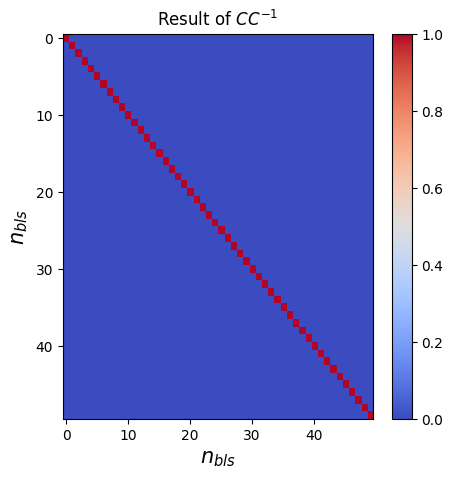

In [16]:
fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cp.asnumpy(C@C_inv), cmap = 'coolwarm', aspect='auto')
ax.set_title("Result of $CC^{-1}$")
ax.set_xlabel("$n_{bls}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

Since the entries along the main diagonal appear to be one, while all other entries appear to be zero, this plot seems to represent the identity. This further validates the correctness of our solutions!

### Timing Tests

We would finally like to benchmark the main routine in this notebook responsible for calculating the sparse inverse covariance objects. After all, the hope is that the cupy/python implimentation will still be faster than the existing C-backend version of corrcal. We begin by first defining, then retreiving the necessary parameters.

In [38]:
#the main parametes describing our problem.
n_bl = 1000
n_eig = 3
n_src = 6
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 10))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl)**2   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig)
sim_src_mat = xp.random.rand(n_bl, n_src)

#actually go and find inverse components
N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat, sim_diff_mat, sim_src_mat, edges=edges, xp = xp)

The edges of the redundant blocks have indices[   0   25  169  203  444  469  492  731  752  863  901 1000]


Finally, we use the cupy benchmark routine to measure the time that is spent on both the cpu and the gpu during the computation (in this case the inverse_covariance function) of interest.

In [39]:
test_results = str(benchmark(inverse_covariance, (sim_noise_mat, sim_diff_mat, sim_src_mat, edges, xp), n_repeat=100))
test_results = test_results.split()
cpu_t = float(test_results[3])/1e6
gpu_t = float(test_results[14])/1e6
print(f"Time on cpu: {cpu_t:.6f}s")
print(f"Time on gpu: {gpu_t:.6f}s")

Time on cpu: 0.028670s
Time on gpu: 0.028722s
